# 1. Quick overview (what we'll do)

1. Prepare a small dataset (structure explained) or use images you upload to Colab / Google Drive.
2. Load data with `torchvision.datasets.ImageFolder` + transforms.
3. Use transfer learning with a pretrained `resnet18` (fast and good for portfolio).
4. Train, validate, save model, and run a few predictions.
5. Add a simple confusion matrix and Grad-CAM suggestion for visual explainability (nice for portfolio).

---

# 2. Folder / dataset layout (simple)

Create a local folder with this structure (or put it in Google Drive and mount it in Colab):

```
food_dataset/
  train/
    pizza/
      pizza1.jpg
      pizza2.jpg
    salad/
      salad1.jpg
      ...
  val/
    pizza/
      ...
    salad/
      ...
  test/
    pizza/
      ...
    salad/
      ...
```

In [1]:
# Install / upgrade PyTorch if needed (Colab has torch preinstalled usually)
!pip install -q torch torchvision

---

# 4. Imports and device

In [2]:
import os
import time
import copy
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


---

# 5. Data transforms and loaders

In [19]:
# Set this to your dataset path
dataset_path = "/content/drive/MyDrive/food_dataset_split"

# Basic transforms: resize, center-crop, normalization (ImageNet stats)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'), num_workers=2)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print("Classes:", class_names)
print("Sizes:", dataset_sizes)

Classes: ['baklava', 'cheesecake', 'donuts', 'macarons', 'omelette', 'pizza', 'scallops', 'steak', 'tacos', 'waffles']
Sizes: {'train': 8000, 'val': 1000, 'test': 1000}


---

# 6. Build model (transfer learning)

We’ll use a pretrained ResNet18 and only fine-tune the final layer (fast, performs well).

In [20]:
num_classes = len(class_names)
model = models.resnet18(pretrained=True)

# Freeze all layers (optional). If you have enough images, you can unfreeze later.
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---

# 7. Loss, optimizer, scheduler

In [21]:
criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Optional learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

---

# 8. Training loop (simple & clear)

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Run training (adjust epochs as needed)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)

Epoch 1/8
----------
train Loss: 1.1808 Acc: 0.6136
val Loss: 0.7363 Acc: 0.7570

Epoch 2/8
----------
train Loss: 1.0389 Acc: 0.6775
val Loss: 0.7234 Acc: 0.7660

Epoch 3/8
----------
train Loss: 0.9543 Acc: 0.6991
val Loss: 0.8218 Acc: 0.7600

Epoch 4/8
----------
train Loss: 0.9107 Acc: 0.7145
val Loss: 0.6300 Acc: 0.7940

Epoch 5/8
----------
train Loss: 0.9307 Acc: 0.7111
val Loss: 0.7011 Acc: 0.7760

Epoch 6/8
----------
train Loss: 0.9537 Acc: 0.7084
val Loss: 0.6875 Acc: 0.7790

Epoch 7/8
----------
train Loss: 0.9432 Acc: 0.7131
val Loss: 0.6942 Acc: 0.8010

Epoch 8/8
----------
train Loss: 0.7324 Acc: 0.7684
val Loss: 0.5757 Acc: 0.8130

Training complete in 8m 23s
Best val Acc: 0.8130


---

# 9. Save the model

In [23]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, '/content/drive/MyDrive/food_resnet18.pth')

---

# 10. Evaluate on test set & show classification report

In [24]:
# Put model in eval
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

     baklava       0.82      0.70      0.76       100
  cheesecake       0.75      0.75      0.75       100
      donuts       0.77      0.76      0.76       100
    macarons       0.88      0.92      0.90       100
    omelette       0.82      0.82      0.82       100
       pizza       0.84      0.87      0.86       100
    scallops       0.71      0.76      0.73       100
       steak       0.74      0.75      0.75       100
       tacos       0.84      0.81      0.82       100
     waffles       0.75      0.78      0.76       100

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



Optional: confusion matrix visualization:

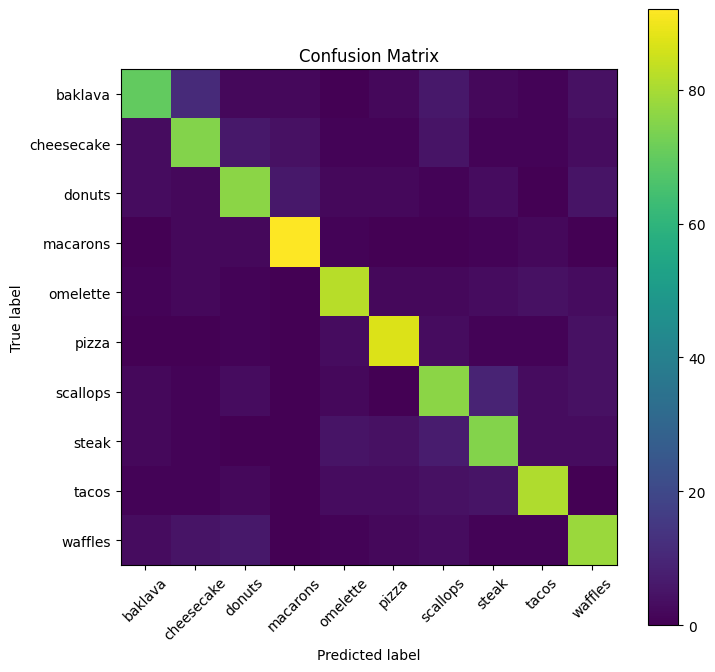

In [25]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

---

# 11. Single-image inference (demo function)

In [26]:
from PIL import Image

def predict_image(image_path, model, class_names, transform):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        probs = torch.nn.functional.softmax(out, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

# Example:
label, confidence = predict_image('/content/baklava_test.jpg', model, class_names, data_transforms['test'])
print(label, confidence)

baklava 0.7926720976829529
